# Segmentation

### Import data and libraries

In [ ]:
!curl -L -C - -o 'data.zip' 'https://drive.google.com/u/0/uc?id=1Z40U9xNbRu8pUkgqBLRXqGN3kiZmGHvZ&export=download&confirm=t' #oko 100 slika
# https://drive.google.com/file/d/1Z40U9xNbRu8pUkgqBLRXqGN3kiZmGHvZ/view?usp=share_link

!curl -L -C - -o 'all_data.zip' 'https://drive.google.com/u/0/uc?id=19ZSSBdciEtbs5ppKzjAWIgr5ydjZ6mba&export=download&confirm=t' #sve slike
# https://drive.google.com/file/d/1HF5Pzb25dL0TCWNjIvXGII_0g_PJVPS4/view?usp=share_link
# https://drive.google.com/file/d/19ZSSBdciEtbs5ppKzjAWIgr5ydjZ6mba/view?usp=drive_link

# !curl -L -C - -o 'final_model.pkl' 'https://drive.google.com/u/0/uc?id=1d6yJYBy0PEZjLqtHK52s82T0Gufj__wu&export=download&confirm=t' # stari model
# https://drive.google.com/file/d/1d6yJYBy0PEZjLqtHK52s82T0Gufj__wu/view?usp=sharing

!curl -L -C - -o 'new_final_model.pkl' 'https://drive.google.com/u/0/uc?id=1SogmECU4-i7nskqEaJBQH90TYVbu7M9O&export=download&confirm=t' #model
# https://drive.google.com/file/d/1SogmECU4-i7nskqEaJBQH90TYVbu7M9O/view?usp=drive_link

** Resuming transfer from byte position 7019965
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
** Resuming transfer from byte position 136474859
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
** Resuming transfer from byte position 31138674
  % Total    % Received % Xferd  Average Speed   Time    Time  

In [ ]:
!unzip -n data.zip
!unzip -n all_data.zip

Archive:  data.zip
Archive:  all_data.zip


In [ ]:
import numpy as np
import tqdm as tqdm
import os
import traceback
import cv2
import glob
import os
import matplotlib.pyplot as plt
import torchvision
import time
from torch.utils.data import DataLoader, Dataset
from torch import nn
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pickle
!pip install torchmetrics
from torchmetrics.classification import BinaryJaccardIndex
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Create dir for storing models if not existing

In [ ]:
!mkdir /content/outputs

mkdir: cannot create directory ‘/content/outputs’: File exists


### Displaying and image and mask from dataset

In [ ]:
image_path = os.path.join('/content/data_square/images')
mask_path = os.path.join('/content/data_square/masks')

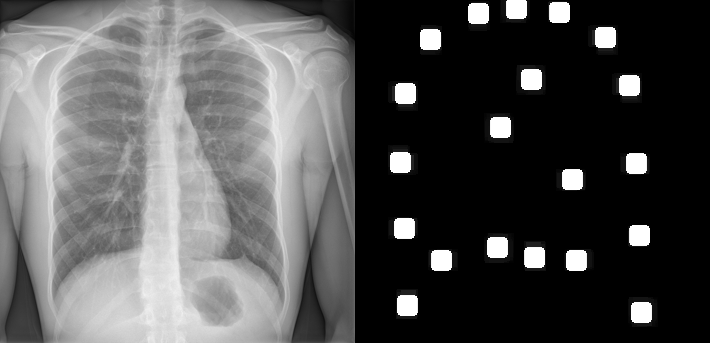

In [ ]:
img = cv2.imread(image_path +'/VCX_s0000001_i1_PA.jpg')
mask = cv2.imread(mask_path + '/VCX_s0000001_i1_PA.jpg')
kernel = np.ones((15, 15), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)
hor = np.concatenate((img, mask), axis=1)
cv2_imshow(hor)

## Functions and classes

### Classes

In [ ]:
class UNet(nn.Module):
    def __init__(self, input_size=(112,112,1)):
        super(UNet, self).__init__()

        self.input_size = input_size

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(256),
                                  nn.ReLU())
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(512),
                                  nn.ReLU())

        self.up6 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(256),
                                  nn.ReLU())

        self.up7 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(128),
                                  nn.ReLU())

        self.up8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.conv8 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                  nn.ReLU())

        self.up9 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.conv9 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(32),
                                  nn.ReLU())

        self.conv10 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print(x.shape)
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)
        #print(conv1.shape)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv4(pool3)
        pool4 = self.pool4(conv4)

        conv5 = self.conv5(pool4)

        up6 = self.up6(conv5)
        up6 = torch.cat((up6, conv4), dim=1)
        conv6 = self.conv6(up6)

        up7 = self.up7(conv6)
        up7 = torch.cat((up7, conv3), dim=1)
        conv7 = self.conv7(up7)

        up8 = self.up8(conv7)
        up8 = torch.cat((up8, conv2), dim=1)
        conv8 = self.conv8(up8)

        up9 = self.up9(conv8)
        up9 = torch.cat((up9, conv1), dim=1)
        conv9 = self.conv9(up9)

        output = self.conv10(conv9)

        return output

In [ ]:
class SegmentationData(Dataset):
    def __init__(self):

        self.items = os.listdir(mask_path)

    def __len__(self):
        return len(self.items)



    def __getitem__(self, ix):

        name = self.items[ix]

        img = cv2.imread(os.path.join(image_path, name))
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_NEAREST)[:,:,0] / img.max()

        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor[None, :]

        # if self.transform is not None:
        #     img = self.transform(img)

        mask = cv2.imread(os.path.join(mask_path, name))
        mask = cv2.resize(mask, (224,224), interpolation = cv2.INTER_NEAREST)[:,:,0] / mask.max()

        ### Koristiti dilataciju da se povecaju krugovi
        kernel = np.ones((15, 15), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=1)

        mask_tensor = torch.from_numpy(mask)

        return img_tensor.float(), mask_tensor.float(), name

### Functions

In [ ]:
def save_model(epochs, model, optimizer, criterion):
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"/content/outputs/model_epoch_{epochs}.pth")


In [ ]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    return ce_loss

In [ ]:
def UnetAccuracy(preds, targets):
    metric = BinaryJaccardIndex().to(device)
    return metric(preds, targets)

In [ ]:
def combine_outputs(outputs):
    list_of_tensors = []
    counter = 0
    for pred_mask in outputs:
        counter += 1
        pred_mask = pred_mask.permute(1,2,0).cpu().detach().numpy()
        firstChannelMask = pred_mask[:,:,0]
        firstChannelMask[firstChannelMask <= firstChannelMask.mean()] = 0
        firstChannelMask[firstChannelMask > firstChannelMask.mean()] = 1

        secondChannelMask = pred_mask[:,:,1]
        secondChannelMask[secondChannelMask <= secondChannelMask.mean()] = 0
        secondChannelMask[secondChannelMask > secondChannelMask.mean()] = 1

        mask_pred = 1 - (firstChannelMask - secondChannelMask)
        threshold = mask_pred.mean()

        mask_pred[mask_pred <= threshold] = 0
        mask_pred[mask_pred > threshold] = 1
        mask_pred.astype(np.int8)
        mask_pred = torch.from_numpy(mask_pred)

        # # Error Analysis
        # if counter <= 3 and counter != 2:
        #   print("Predicted mask", counter)
        #   plt.imshow(mask_pred, cmap='gray')
        #   plt.show()
        #   time.sleep(0.1)

        list_of_tensors.append(mask_pred)

    return torch.stack(list_of_tensors)

In [ ]:
def train(model, trainloader, optimizer, criterion, accuracy_func):
    model = model.to(device)
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    acc_total = 0
    for i, data in tqdm.tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, masks, names = data
        image = image.to(device)
        masks = masks.to(device)

        outputs = model(image)
        optimizer.zero_grad()

        # Calculate the loss
        loss = criterion(outputs, masks.long())

        # L2 regularization
        l2_lambda = 0.001
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param, p=2)
        loss += l2_lambda * l2_reg

        loss.backward() # Backpropogate loss
        optimizer.step() # Apply gradient descent change to weight
        train_running_loss += loss.item()

        outputs_combined = combine_outputs(outputs)
        outputs_combined = outputs_combined.to(device)
        acc = accuracy_func(outputs_combined, masks.long())
        acc_total += acc

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    acc_avg = acc_total / counter
    return epoch_loss, acc_avg

In [ ]:
def validate(model, validloader, criterion, accuracy_func):
    # Validation phase
    model.eval()
    valid_loss_epoch = 0.0
    valid_correct = 0
    valid_counter = 0
    valid_acc_total = 0

    with torch.no_grad():
      for i, data in tqdm.tqdm(enumerate(validloader), total=len(validloader)):

        valid_counter += 1
        image, masks, names = data
        image = image.to(device)
        masks = masks.to(device)

        # print("\nImage - original mask 1")
        # error_analysis1(image[0].unsqueeze(0), masks, 0)
        # print("\nImage - original mask 3")
        # error_analysis1(image[2].unsqueeze(0), masks, 2)

        outputs = model(image)
        valid_loss_epoch += criterion(outputs, masks.long()).item()

        outputs_combined = combine_outputs(outputs)
        outputs_combined = outputs_combined.to(device)

        # print("Image - predicted mask 1")
        # error_analysis2(image[0].unsqueeze(0), outputs_combined, 0)
        # print("Image - predicted mask 3")
        # error_analysis2(image[2].unsqueeze(0), outputs_combined, 2)

        valid_acc_total += accuracy_func(outputs_combined, masks.long()).item()

        # break # show only 2 images and masks

    valid_epoch_loss = valid_loss_epoch / valid_counter
    valid_epoch_acc = valid_acc_total / valid_counter

    return valid_epoch_loss, valid_epoch_acc


In [ ]:
def test(model, testloader, criterion, accuracy_func):
  model.eval()
  test_loss = 0
  test_acc = 0

  with torch.no_grad():
    for i, data in tqdm.tqdm(enumerate(testloader), total=len(testloader)):
      image, masks, names = data

      image = image.to(device)
      masks = masks.to(device)

      # Forward pass
      outputs = model(image)
      # print(outputs)
      loss = criterion(outputs, masks.long())
      test_loss += loss.item()

      outputs_combined = combine_outputs(outputs)
      pred_mask = outputs_combined.to(device)

      # Calculate accuracy
      acc = accuracy_func(pred_mask, masks.long())
      test_acc += acc.item()

    test_loss /= len(testloader)
    test_acc /= len(testloader)

    return test_loss, test_acc

In [ ]:
def show_landmarks(image, landmarks, name):
    plt.imshow(image, cmap = 'gray')
    for i in range(len(landmarks)):
        plt.scatter(landmarks[i][0], landmarks[i][1], s=10, marker='.', c='r')
    plt.title(name)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
def error_analysis1(img, msk, ix):
  image = img[0].squeeze().cpu().detach().numpy()
  mask = msk[ix].squeeze()
  mask = mask.cpu().detach().numpy()
  # kernel = np.ones((15, 15), np.uint8)
  # mask = cv2.erode(mask, kernel, iterations=1)
  # mask = torch.from_numpy(mask)
  plt.imshow(image - image * mask, cmap='gray')
  plt.show()
  time.sleep(0.1)
  return

In [ ]:
def error_analysis2(img, msk, ix):
  image = img[0].squeeze().cpu().detach().numpy()
  mask = msk[ix].squeeze().cpu().detach().numpy()
  kernel = np.ones((1, 1), np.uint8)
  mask = cv2.dilate(mask, kernel, iterations=1)
  # mask = torch.from_numpy(mask)
  plt.imshow(image - image * mask, cmap='gray')
  plt.show()
  time.sleep(0.1)
  return

In [ ]:
# https://wandb.ai/ishandutta/semantic_segmentation_unet/reports/Semantic-Segmentation-with-UNets-in-PyTorch--VmlldzoyMzA3MTk1

## Training phase

In [ ]:
train_ds = SegmentationData()
print("Dataset length:", len(train_ds))
train_data_loader = DataLoader(train_ds, batch_size=16, num_workers = 2, shuffle=True)
model = UNet()
epochs = 100
learning_rate = 0.0001
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = UnetLoss
accuracy_func = UnetAccuracy

Dataset length: 108


In [ ]:
train_loss, accuracy_list = [], []
patience = 7
best_model = model
last_train_epoch_loss = 1000
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, acc = train(model, train_data_loader, optimizer, criterion, accuracy_func)

    if last_train_epoch_loss < train_epoch_loss:
        trigger_times += 1
        print('Trigger Times:', trigger_times)

        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            break

    else:
        best_model = model
        print('trigger times: 0')
        trigger_times = 0

        last_train_epoch_loss = train_epoch_loss

        # Save the trained model weights.
        save_model(epoch, best_model, optimizer, criterion)

    train_loss.append(train_epoch_loss)
    accuracy_list.append(acc)

    print(f"Training loss: {train_epoch_loss:.3f}")
    print(f"Acc: {acc:.3f}")
    print('-'*50)

    time.sleep(1)

[INFO]: Epoch 1 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


trigger times: 0
Training loss: 1.010
Acc: 0.123
--------------------------------------------------
[INFO]: Epoch 2 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


trigger times: 0
Training loss: 0.940
Acc: 0.136
--------------------------------------------------
[INFO]: Epoch 3 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


trigger times: 0
Training loss: 0.894
Acc: 0.127
--------------------------------------------------
[INFO]: Epoch 4 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


trigger times: 0
Training loss: 0.857
Acc: 0.143
--------------------------------------------------
[INFO]: Epoch 5 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


trigger times: 0
Training loss: 0.822
Acc: 0.172
--------------------------------------------------
[INFO]: Epoch 6 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


trigger times: 0
Training loss: 0.788
Acc: 0.196
--------------------------------------------------
[INFO]: Epoch 7 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


trigger times: 0
Training loss: 0.757
Acc: 0.172
--------------------------------------------------
[INFO]: Epoch 8 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


trigger times: 0
Training loss: 0.727
Acc: 0.147
--------------------------------------------------
[INFO]: Epoch 9 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


trigger times: 0
Training loss: 0.700
Acc: 0.158
--------------------------------------------------
[INFO]: Epoch 10 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


trigger times: 0
Training loss: 0.678
Acc: 0.203
--------------------------------------------------
[INFO]: Epoch 11 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


trigger times: 0
Training loss: 0.660
Acc: 0.260
--------------------------------------------------
[INFO]: Epoch 12 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


trigger times: 0
Training loss: 0.646
Acc: 0.265
--------------------------------------------------
[INFO]: Epoch 13 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


trigger times: 0
Training loss: 0.635
Acc: 0.265
--------------------------------------------------
[INFO]: Epoch 14 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


trigger times: 0
Training loss: 0.626
Acc: 0.260
--------------------------------------------------
[INFO]: Epoch 15 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.619
Acc: 0.259
--------------------------------------------------
[INFO]: Epoch 16 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


trigger times: 0
Training loss: 0.611
Acc: 0.256
--------------------------------------------------
[INFO]: Epoch 17 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


trigger times: 0
Training loss: 0.605
Acc: 0.257
--------------------------------------------------
[INFO]: Epoch 18 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


trigger times: 0
Training loss: 0.599
Acc: 0.258
--------------------------------------------------
[INFO]: Epoch 19 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


trigger times: 0
Training loss: 0.594
Acc: 0.262
--------------------------------------------------
[INFO]: Epoch 20 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


trigger times: 0
Training loss: 0.588
Acc: 0.261
--------------------------------------------------
[INFO]: Epoch 21 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.582
Acc: 0.261
--------------------------------------------------
[INFO]: Epoch 22 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.577
Acc: 0.262
--------------------------------------------------
[INFO]: Epoch 23 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


trigger times: 0
Training loss: 0.571
Acc: 0.267
--------------------------------------------------
[INFO]: Epoch 24 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.567
Acc: 0.279
--------------------------------------------------
[INFO]: Epoch 25 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.563
Acc: 0.283
--------------------------------------------------
[INFO]: Epoch 26 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


trigger times: 0
Training loss: 0.560
Acc: 0.271
--------------------------------------------------
[INFO]: Epoch 27 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


trigger times: 0
Training loss: 0.556
Acc: 0.262
--------------------------------------------------
[INFO]: Epoch 28 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


trigger times: 0
Training loss: 0.552
Acc: 0.266
--------------------------------------------------
[INFO]: Epoch 29 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.549
Acc: 0.269
--------------------------------------------------
[INFO]: Epoch 30 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


trigger times: 0
Training loss: 0.546
Acc: 0.276
--------------------------------------------------
[INFO]: Epoch 31 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.542
Acc: 0.288
--------------------------------------------------
[INFO]: Epoch 32 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.538
Acc: 0.300
--------------------------------------------------
[INFO]: Epoch 33 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


trigger times: 0
Training loss: 0.535
Acc: 0.318
--------------------------------------------------
[INFO]: Epoch 34 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


trigger times: 0
Training loss: 0.532
Acc: 0.327
--------------------------------------------------
[INFO]: Epoch 35 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


trigger times: 0
Training loss: 0.528
Acc: 0.345
--------------------------------------------------
[INFO]: Epoch 36 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


trigger times: 0
Training loss: 0.525
Acc: 0.376
--------------------------------------------------
[INFO]: Epoch 37 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


trigger times: 0
Training loss: 0.522
Acc: 0.394
--------------------------------------------------
[INFO]: Epoch 38 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


trigger times: 0
Training loss: 0.518
Acc: 0.423
--------------------------------------------------
[INFO]: Epoch 39 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.515
Acc: 0.440
--------------------------------------------------
[INFO]: Epoch 40 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


trigger times: 0
Training loss: 0.513
Acc: 0.461
--------------------------------------------------
[INFO]: Epoch 41 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


trigger times: 0
Training loss: 0.510
Acc: 0.478
--------------------------------------------------
[INFO]: Epoch 42 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.509
Acc: 0.493
--------------------------------------------------
[INFO]: Epoch 43 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.506
Acc: 0.517
--------------------------------------------------
[INFO]: Epoch 44 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.503
Acc: 0.531
--------------------------------------------------
[INFO]: Epoch 45 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


trigger times: 0
Training loss: 0.501
Acc: 0.546
--------------------------------------------------
[INFO]: Epoch 46 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.498
Acc: 0.556
--------------------------------------------------
[INFO]: Epoch 47 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


trigger times: 0
Training loss: 0.496
Acc: 0.580
--------------------------------------------------
[INFO]: Epoch 48 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


trigger times: 0
Training loss: 0.494
Acc: 0.584
--------------------------------------------------
[INFO]: Epoch 49 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


trigger times: 0
Training loss: 0.491
Acc: 0.608
--------------------------------------------------
[INFO]: Epoch 50 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


trigger times: 0
Training loss: 0.489
Acc: 0.614
--------------------------------------------------
[INFO]: Epoch 51 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


trigger times: 0
Training loss: 0.487
Acc: 0.628
--------------------------------------------------
[INFO]: Epoch 52 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


trigger times: 0
Training loss: 0.485
Acc: 0.642
--------------------------------------------------
[INFO]: Epoch 53 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


trigger times: 0
Training loss: 0.482
Acc: 0.657
--------------------------------------------------
[INFO]: Epoch 54 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


trigger times: 0
Training loss: 0.480
Acc: 0.664
--------------------------------------------------
[INFO]: Epoch 55 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


trigger times: 0
Training loss: 0.479
Acc: 0.674
--------------------------------------------------
[INFO]: Epoch 56 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


trigger times: 0
Training loss: 0.476
Acc: 0.687
--------------------------------------------------
[INFO]: Epoch 57 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


trigger times: 0
Training loss: 0.475
Acc: 0.695
--------------------------------------------------
[INFO]: Epoch 58 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


trigger times: 0
Training loss: 0.475
Acc: 0.693
--------------------------------------------------
[INFO]: Epoch 59 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


trigger times: 0
Training loss: 0.474
Acc: 0.713
--------------------------------------------------
[INFO]: Epoch 60 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


trigger times: 0
Training loss: 0.472
Acc: 0.705
--------------------------------------------------
[INFO]: Epoch 61 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


trigger times: 0
Training loss: 0.469
Acc: 0.725
--------------------------------------------------
[INFO]: Epoch 62 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


trigger times: 0
Training loss: 0.468
Acc: 0.727
--------------------------------------------------
[INFO]: Epoch 63 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


trigger times: 0
Training loss: 0.466
Acc: 0.739
--------------------------------------------------
[INFO]: Epoch 64 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.463
Acc: 0.752
--------------------------------------------------
[INFO]: Epoch 65 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.460
Acc: 0.760
--------------------------------------------------
[INFO]: Epoch 66 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


trigger times: 0
Training loss: 0.458
Acc: 0.770
--------------------------------------------------
[INFO]: Epoch 67 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


trigger times: 0
Training loss: 0.456
Acc: 0.780
--------------------------------------------------
[INFO]: Epoch 68 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


trigger times: 0
Training loss: 0.455
Acc: 0.783
--------------------------------------------------
[INFO]: Epoch 69 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


trigger times: 0
Training loss: 0.453
Acc: 0.798
--------------------------------------------------
[INFO]: Epoch 70 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


trigger times: 0
Training loss: 0.451
Acc: 0.799
--------------------------------------------------
[INFO]: Epoch 71 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.450
Acc: 0.813
--------------------------------------------------
[INFO]: Epoch 72 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.448
Acc: 0.815
--------------------------------------------------
[INFO]: Epoch 73 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.446
Acc: 0.828
--------------------------------------------------
[INFO]: Epoch 74 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


trigger times: 0
Training loss: 0.444
Acc: 0.830
--------------------------------------------------
[INFO]: Epoch 75 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.442
Acc: 0.841
--------------------------------------------------
[INFO]: Epoch 76 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


trigger times: 0
Training loss: 0.440
Acc: 0.846
--------------------------------------------------
[INFO]: Epoch 77 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.439
Acc: 0.856
--------------------------------------------------
[INFO]: Epoch 78 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


trigger times: 0
Training loss: 0.437
Acc: 0.860
--------------------------------------------------
[INFO]: Epoch 79 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.435
Acc: 0.871
--------------------------------------------------
[INFO]: Epoch 80 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


trigger times: 0
Training loss: 0.434
Acc: 0.875
--------------------------------------------------
[INFO]: Epoch 81 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


trigger times: 0
Training loss: 0.432
Acc: 0.884
--------------------------------------------------
[INFO]: Epoch 82 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


trigger times: 0
Training loss: 0.431
Acc: 0.885
--------------------------------------------------
[INFO]: Epoch 83 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


trigger times: 0
Training loss: 0.430
Acc: 0.888
--------------------------------------------------
[INFO]: Epoch 84 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


trigger times: 0
Training loss: 0.429
Acc: 0.891
--------------------------------------------------
[INFO]: Epoch 85 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


trigger times: 0
Training loss: 0.428
Acc: 0.894
--------------------------------------------------
[INFO]: Epoch 86 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Trigger Times: 1
Training loss: 0.429
Acc: 0.890
--------------------------------------------------
[INFO]: Epoch 87 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


trigger times: 0
Training loss: 0.426
Acc: 0.893
--------------------------------------------------
[INFO]: Epoch 88 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


trigger times: 0
Training loss: 0.424
Acc: 0.900
--------------------------------------------------
[INFO]: Epoch 89 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


trigger times: 0
Training loss: 0.422
Acc: 0.903
--------------------------------------------------
[INFO]: Epoch 90 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


trigger times: 0
Training loss: 0.420
Acc: 0.910
--------------------------------------------------
[INFO]: Epoch 91 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


trigger times: 0
Training loss: 0.420
Acc: 0.907
--------------------------------------------------
[INFO]: Epoch 92 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


trigger times: 0
Training loss: 0.419
Acc: 0.909
--------------------------------------------------
[INFO]: Epoch 93 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


trigger times: 0
Training loss: 0.417
Acc: 0.911
--------------------------------------------------
[INFO]: Epoch 94 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


trigger times: 0
Training loss: 0.416
Acc: 0.913
--------------------------------------------------
[INFO]: Epoch 95 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


trigger times: 0
Training loss: 0.415
Acc: 0.916
--------------------------------------------------
[INFO]: Epoch 96 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


trigger times: 0
Training loss: 0.414
Acc: 0.914
--------------------------------------------------
[INFO]: Epoch 97 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


trigger times: 0
Training loss: 0.412
Acc: 0.920
--------------------------------------------------
[INFO]: Epoch 98 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


trigger times: 0
Training loss: 0.412
Acc: 0.917
--------------------------------------------------
[INFO]: Epoch 99 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


trigger times: 0
Training loss: 0.411
Acc: 0.918
--------------------------------------------------
[INFO]: Epoch 100 of 100
Training


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


trigger times: 0
Training loss: 0.409
Acc: 0.921
--------------------------------------------------


Text(0.5, 1.0, 'Accuary')

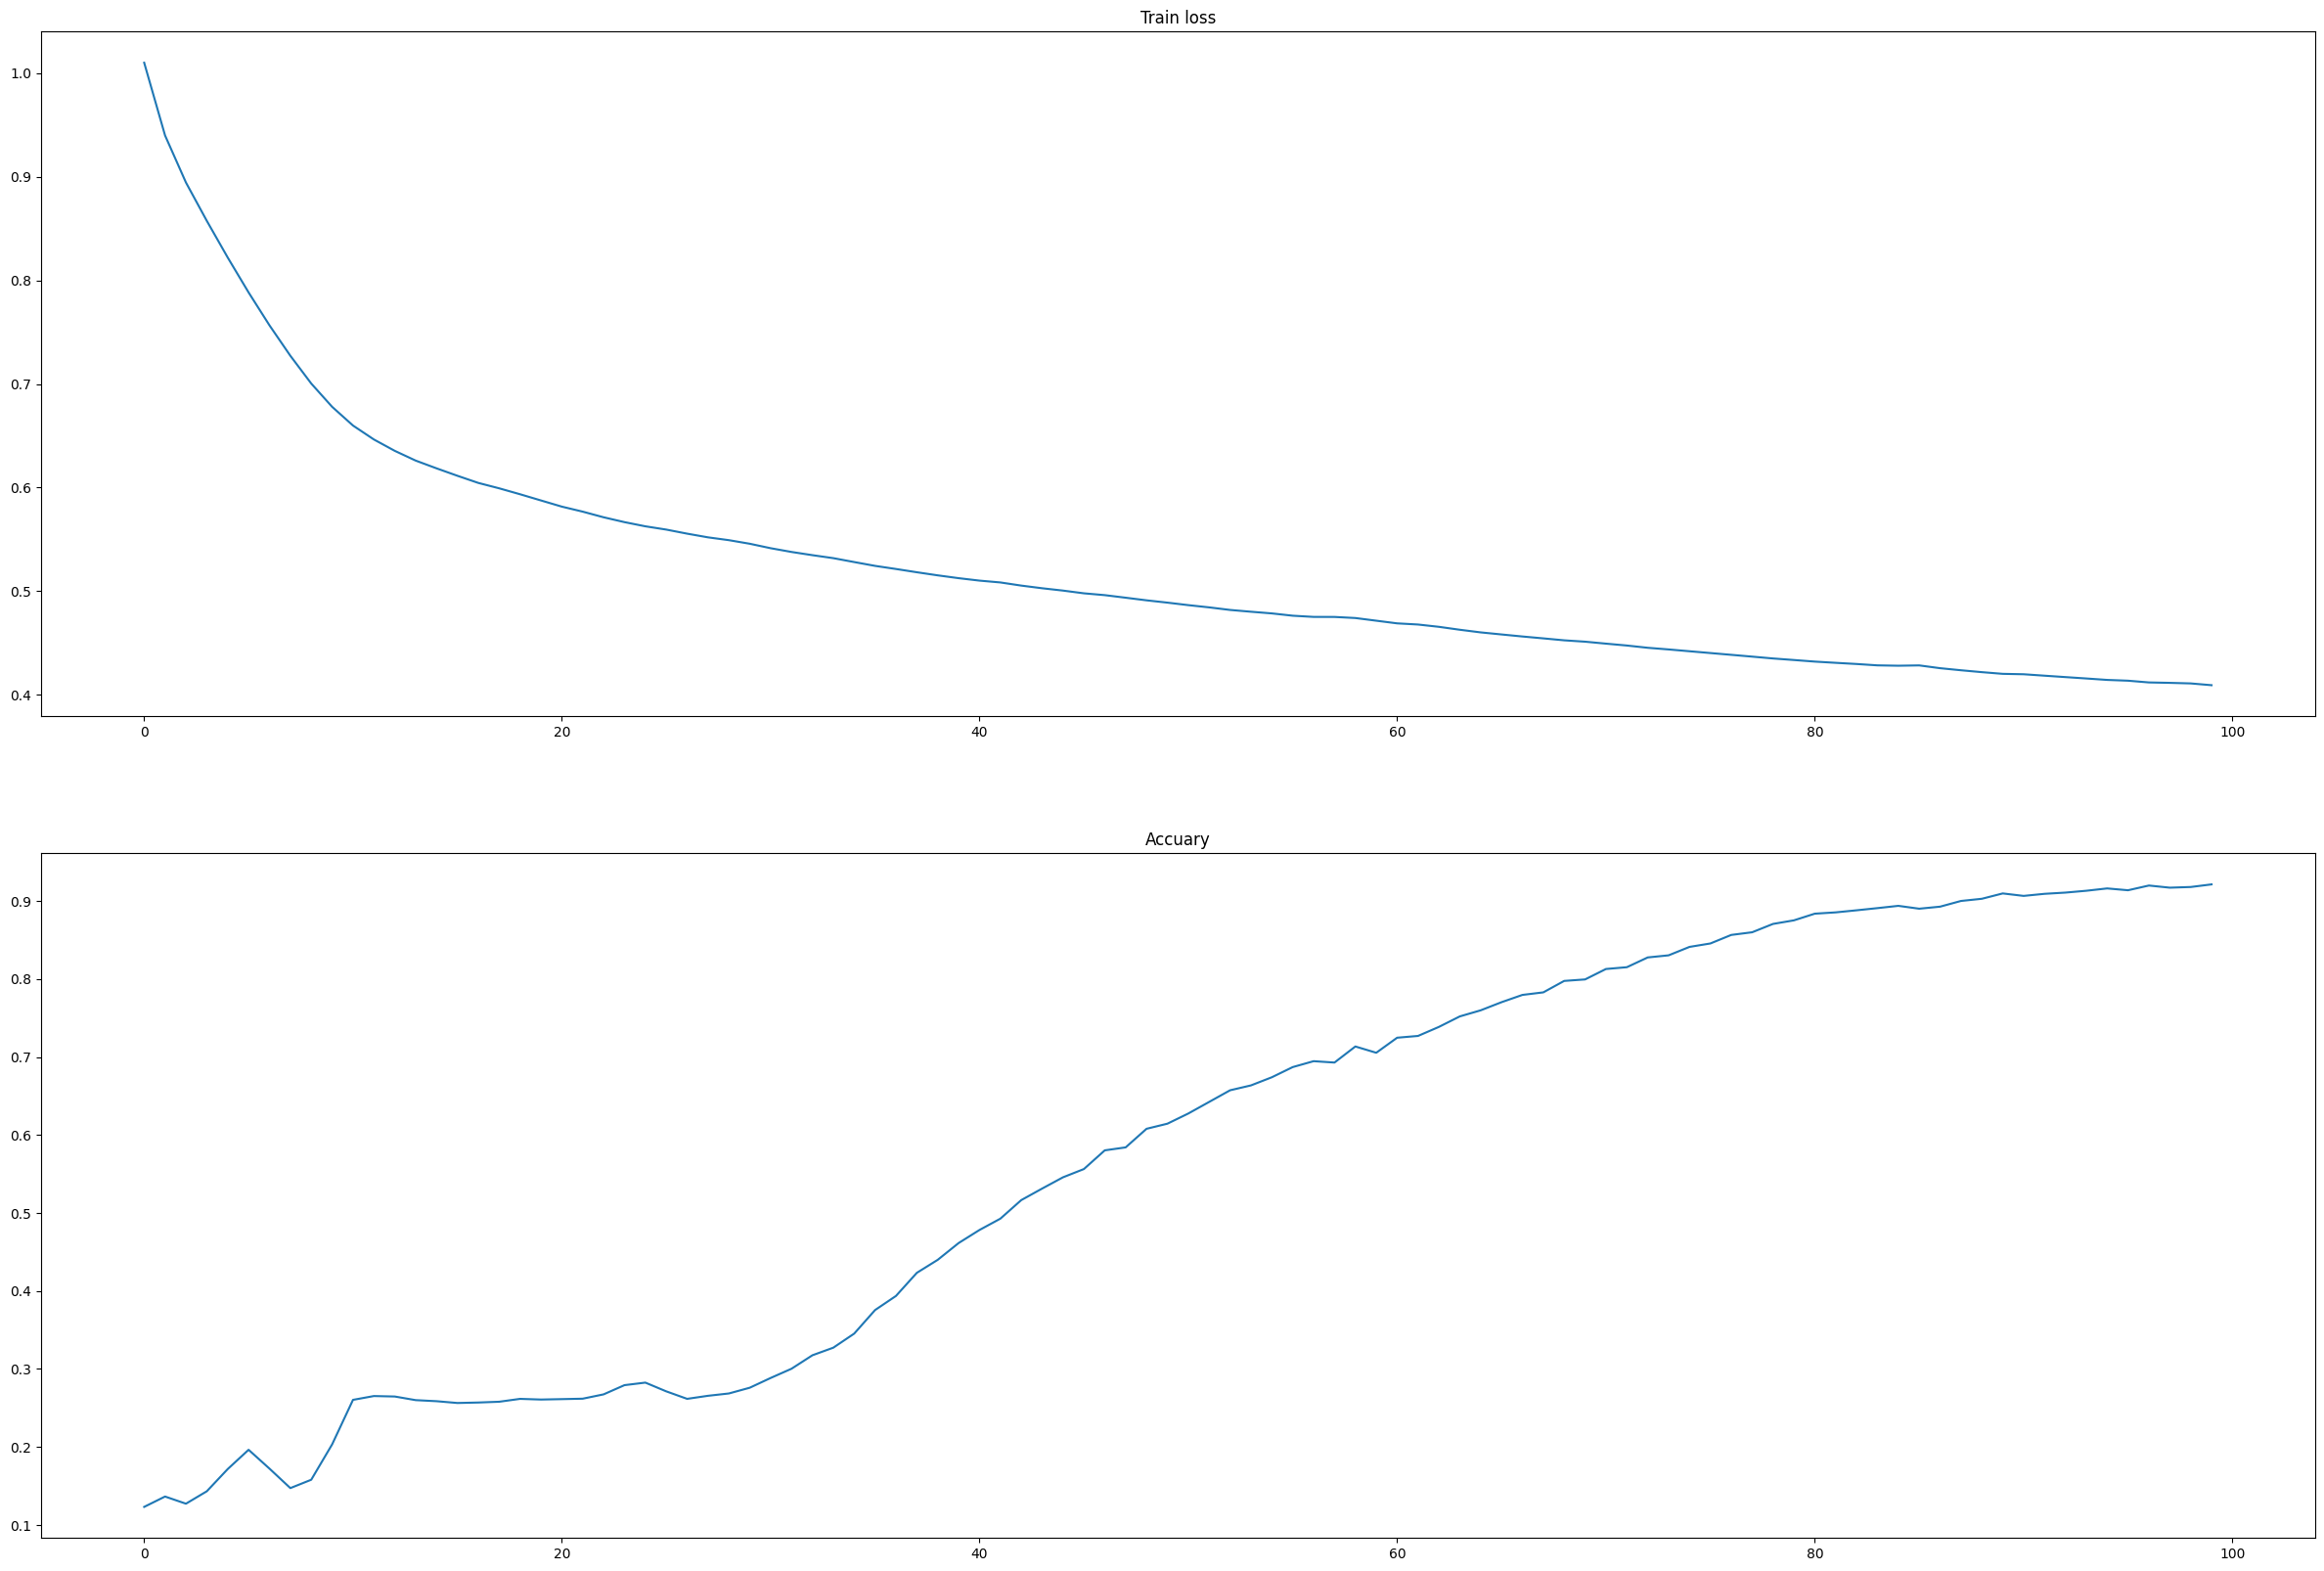

In [ ]:
cpu_tensor_list = [tensor.cpu() for tensor in accuracy_list]

# Convert each tensor to a NumPy array
numpy_array_list = [tensor.numpy() for tensor in cpu_tensor_list]

fig, axs = plt.subplots(2, 1, figsize=(30,20))
axs[0].plot(train_loss)
axs[0].set_title('Train loss')
axs[1].plot(numpy_array_list)
axs[1].set_title('Accuary')

## Dump and load best model

In [ ]:
with open("new_final_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
with open('new_final_model.pkl', 'rb') as f:
  best_model = pickle.load(f)

## Training and validation

In [ ]:
image_path = os.path.join('/content/data_square_all_new/images')
mask_path = os.path.join('/content/data_square_all_new/masks')

In [ ]:
train_ds = SegmentationData()
print("Dataset length:", len(train_ds))
model = UNet()

# with open('final_model.pkl', 'rb') as f:
#   model = pickle.load(f)

learning_rate = 0.0001
epochs = 60
optimizer = torch.optim.Adam(params=best_model.parameters(), lr=learning_rate)
criterion = UnetLoss
accuracy_func = UnetAccuracy
criterion = torch.nn.CrossEntropyLoss()

Dataset length: 2110


In [ ]:
len_test_set = int(0.2*len(train_ds))
len_val_set = int(0.1*len(train_ds))
len_train_set = len(train_ds) - len_val_set - len_test_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_val_set))
print("The length of Test set is {}".format(len_test_set))

gen = torch.Generator().manual_seed(42)
train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(train_ds , [len_train_set, len_val_set, len_test_set], generator=gen)

# shuffle and batch the datasets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

The length of Train set is 1477
The length of Valid set is 211
The length of Test set is 422


In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
patience = 100
best_model = model
valid_loss_min = np.inf

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    # Training phase
    train_epoch_loss, train_epoch_acc = train(model, trainloader, optimizer, criterion, accuracy_func)

    # Validation phase
    valid_epoch_loss, valid_epoch_acc = validate(model, validloader, criterion, accuracy_func)

    if valid_epoch_loss >= valid_loss_min:

        trigger_times += 1
        print('Trigger Times:', trigger_times)

        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            break
    else:
        best_model = model
        print('Trigger times: 0')
        trigger_times = 0
        valid_loss_min = valid_epoch_loss

        # Save the trained model weights.
        save_model(epoch, best_model, optimizer, criterion)

    # Record training and validation losses and accuracies
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}")
    print(f"Training accuracy: {train_epoch_acc:.3f}")
    print(f"Validation accuracy: {valid_epoch_acc:.3f}")
    print('-'*50)

    time.sleep(0.01)

[INFO]: Epoch 1 of 60
Training


100%|██████████| 27/27 [00:01<00:00, 14.90it/s]


Trigger times: 0
Training loss: 1.317
Validation loss: 0.731
Training accuracy: 0.097
Validation accuracy: 0.129
--------------------------------------------------
[INFO]: Epoch 2 of 60
Training


100%|██████████| 27/27 [00:01<00:00, 14.28it/s]

Trigger Times: 1
Training loss: 1.317
Validation loss: 0.812
Training accuracy: 0.097
Validation accuracy: 0.095
--------------------------------------------------
[INFO]: Epoch 3 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 10.70it/s]

Trigger Times: 2
Training loss: 1.317
Validation loss: 0.896
Training accuracy: 0.097
Validation accuracy: 0.093
--------------------------------------------------
[INFO]: Epoch 4 of 60
Training



100%|██████████| 27/27 [00:01<00:00, 13.89it/s]

Trigger Times: 3
Training loss: 1.317
Validation loss: 0.938
Training accuracy: 0.097
Validation accuracy: 0.096
--------------------------------------------------
[INFO]: Epoch 5 of 60
Training



100%|██████████| 27/27 [00:01<00:00, 13.72it/s]

Trigger Times: 4
Training loss: 1.317
Validation loss: 0.943
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 6 of 60
Training



100%|██████████| 27/27 [00:02<00:00,  9.60it/s]

Trigger Times: 5
Training loss: 1.317
Validation loss: 0.944
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 7 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 13.42it/s]

Trigger Times: 6
Training loss: 1.317
Validation loss: 0.947
Training accuracy: 0.098
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 8 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 12.77it/s]

Trigger Times: 7
Training loss: 1.317
Validation loss: 0.946
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 9 of 60
Training



100%|██████████| 27/27 [00:02<00:00,  9.57it/s]


Trigger Times: 8
Training loss: 1.317
Validation loss: 0.945
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 10 of 60
Training


100%|██████████| 27/27 [00:02<00:00, 13.31it/s]

Trigger Times: 9
Training loss: 1.317
Validation loss: 0.945
Training accuracy: 0.098
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 11 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 13.43it/s]

Trigger Times: 10
Training loss: 1.317
Validation loss: 0.946
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 12 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 11.33it/s]

Trigger Times: 11
Training loss: 1.317
Validation loss: 0.945
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 13 of 60
Training



100%|██████████| 27/27 [00:01<00:00, 13.51it/s]

Trigger Times: 12
Training loss: 1.317
Validation loss: 0.945
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 14 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 13.08it/s]

Trigger Times: 13
Training loss: 1.317
Validation loss: 0.944
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 15 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 11.74it/s]

Trigger Times: 14
Training loss: 1.317
Validation loss: 0.945
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 16 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 13.35it/s]

Trigger Times: 15
Training loss: 1.317
Validation loss: 0.942
Training accuracy: 0.098
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 17 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 13.47it/s]

Trigger Times: 16
Training loss: 1.317
Validation loss: 0.944
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 18 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 11.82it/s]

Trigger Times: 17
Training loss: 1.317
Validation loss: 0.943
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 19 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 13.27it/s]

Trigger Times: 18
Training loss: 1.317
Validation loss: 0.943
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 20 of 60
Training



100%|██████████| 27/27 [00:02<00:00, 12.91it/s]

Trigger Times: 19
Training loss: 1.317
Validation loss: 0.945
Training accuracy: 0.097
Validation accuracy: 0.097
--------------------------------------------------
[INFO]: Epoch 21 of 60
Training



 33%|███▎      | 8/24 [00:10<00:19,  1.21s/it]

In [ ]:
from google.colab import files

with open("new_final_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)

files.download('/content/new_final_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

plt.figure(figsize=(10,6))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(["Train loss", "Valid loss"])

plt.savefig('/content/loss_plot.png')
# files.download('/content/loss_plot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

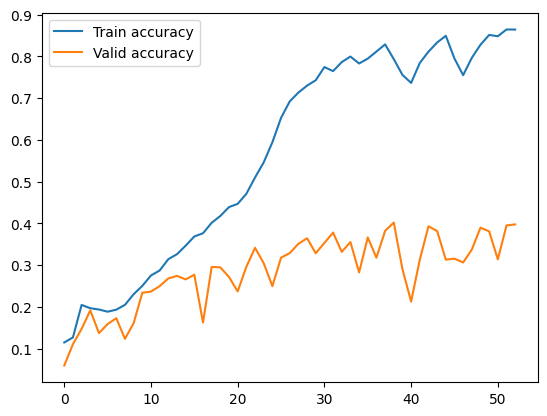

In [ ]:
cpu_tensor_list_train = [tensor.cpu() for tensor in train_acc] # Uncomment the first time you run
train_acc = [tensor.numpy() for tensor in cpu_tensor_list_train]

plt.plot(train_acc)
plt.plot(valid_acc)
plt.legend(["Train accuracy", "Valid accuracy"])

plt.savefig('/content/accuracy_plot.png')
files.download('/content/accuracy_plot.png')

## Validation

  0%|          | 0/27 [00:00<?, ?it/s]

Predicted mask 1


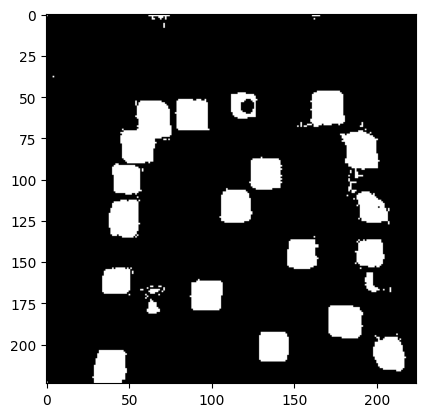

Predicted mask 3


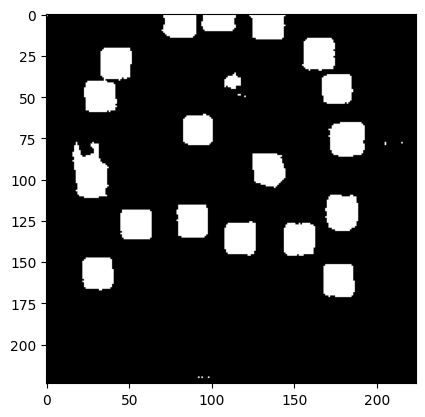

Image - predicted mask 1


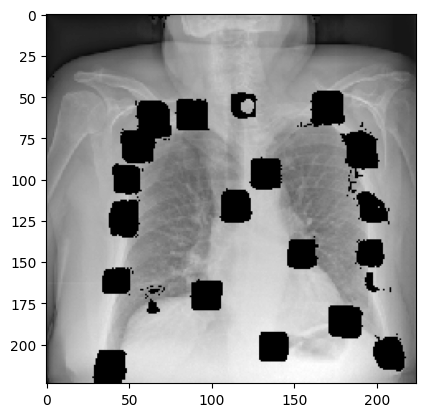

Image - predicted mask 3


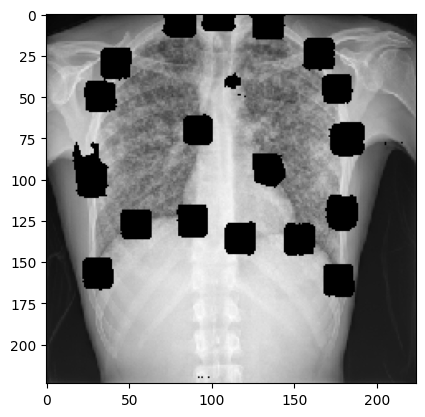

  4%|▎         | 1/27 [00:01<00:43,  1.68s/it]

Predicted mask 1


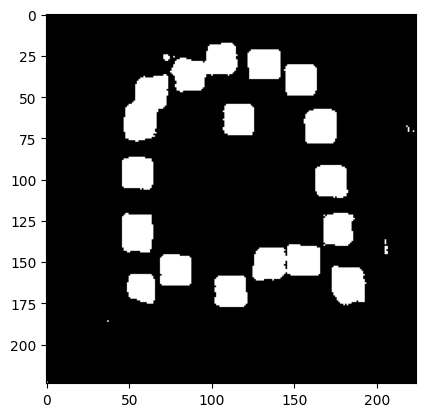

Predicted mask 3


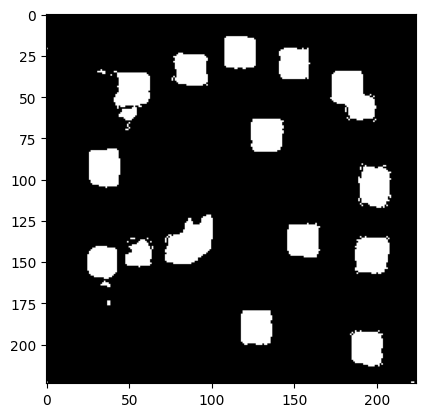

Image - predicted mask 1


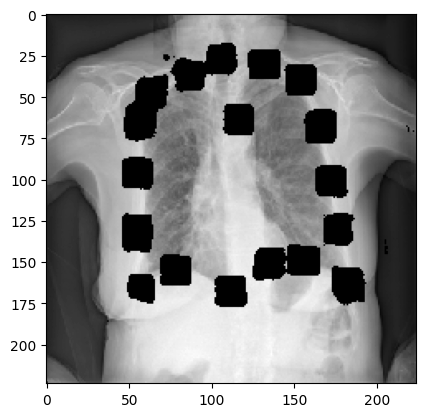

Image - predicted mask 3


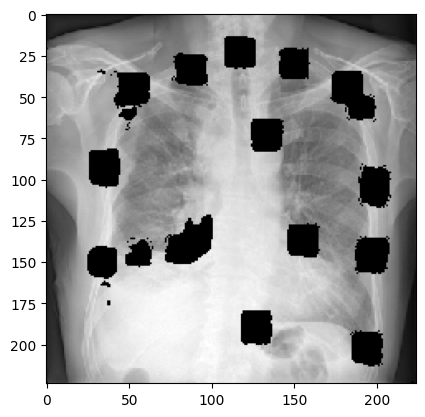

  7%|▋         | 2/27 [00:03<00:41,  1.64s/it]

Predicted mask 1


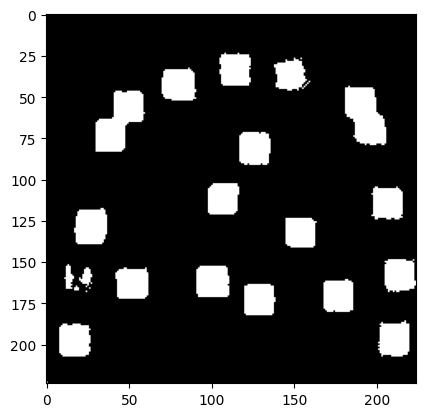

Predicted mask 3


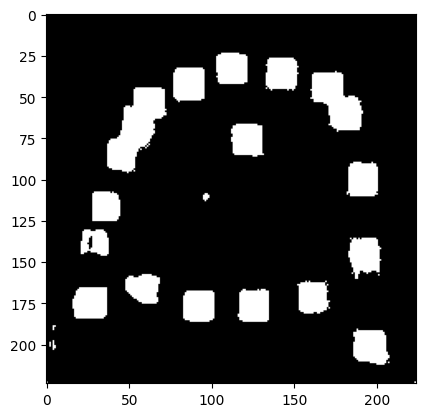

Image - predicted mask 1


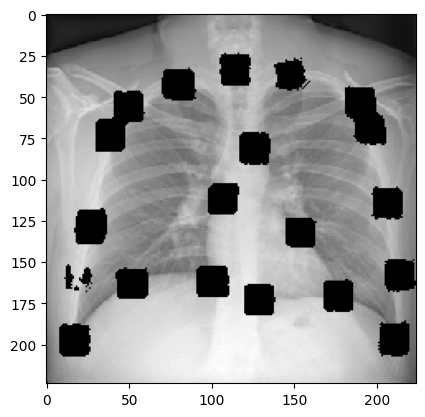

Image - predicted mask 3


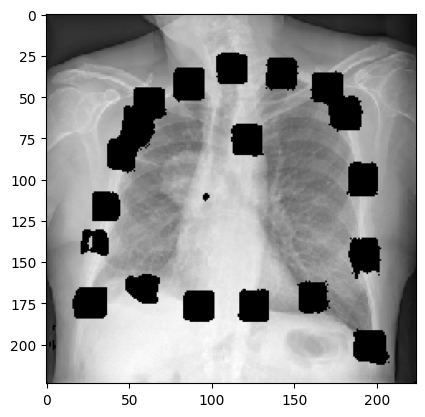

 11%|█         | 3/27 [00:04<00:35,  1.49s/it]

Predicted mask 1


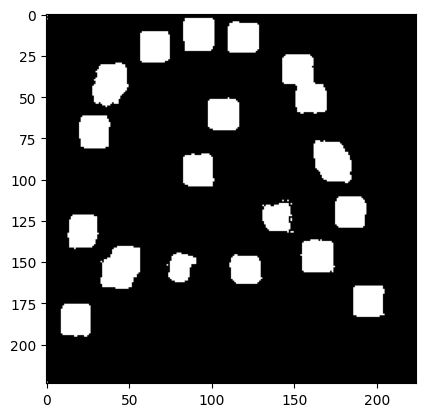

Predicted mask 3


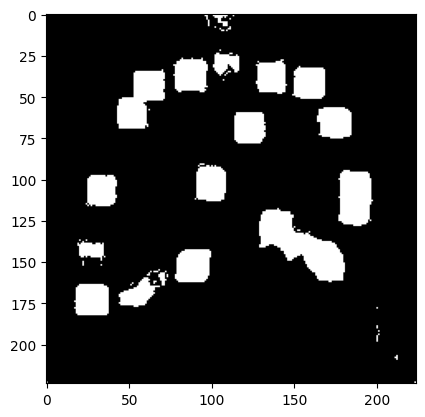

Image - predicted mask 1


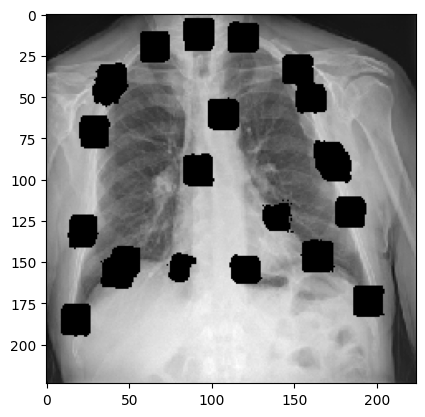

Image - predicted mask 3


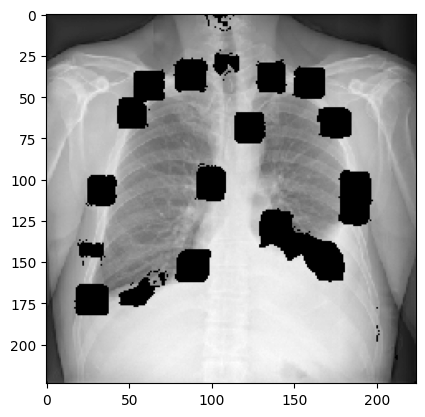

 15%|█▍        | 4/27 [00:05<00:33,  1.44s/it]

Predicted mask 1


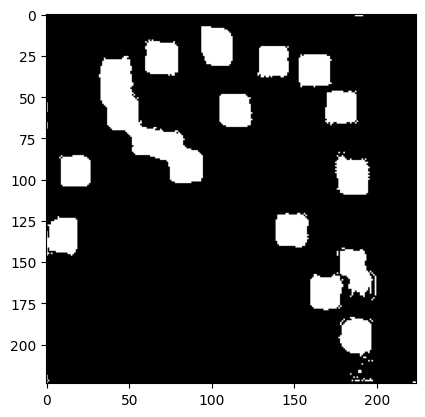

Predicted mask 3


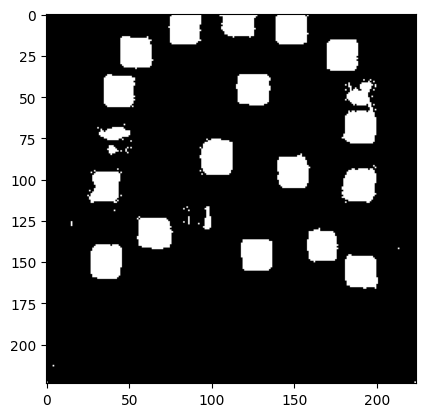

Image - predicted mask 1


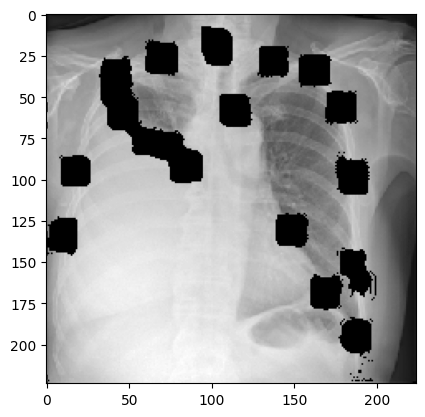

Image - predicted mask 3


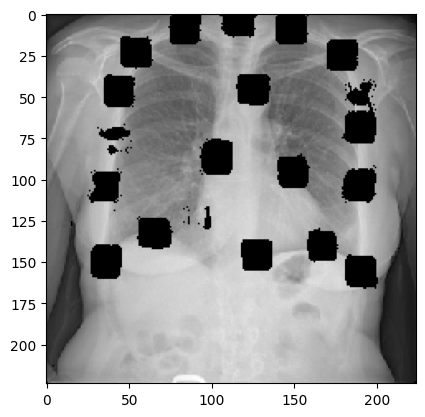

 19%|█▊        | 5/27 [00:07<00:30,  1.40s/it]

Predicted mask 1


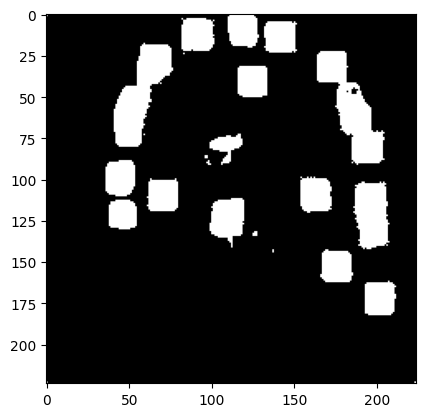

Predicted mask 3


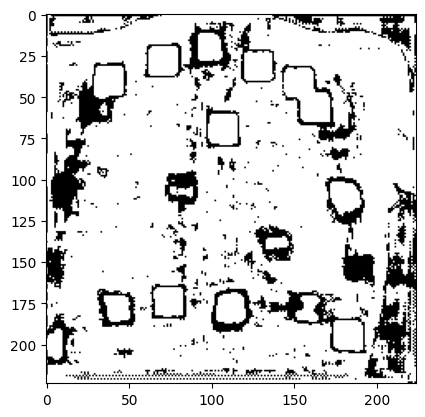

Image - predicted mask 1


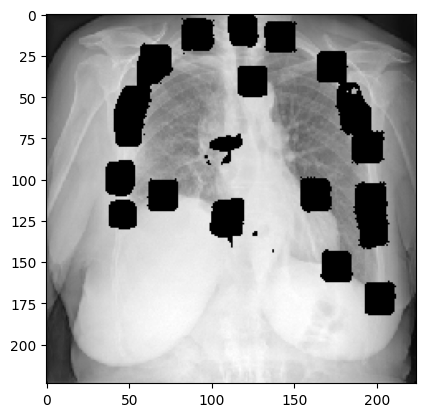

Image - predicted mask 3


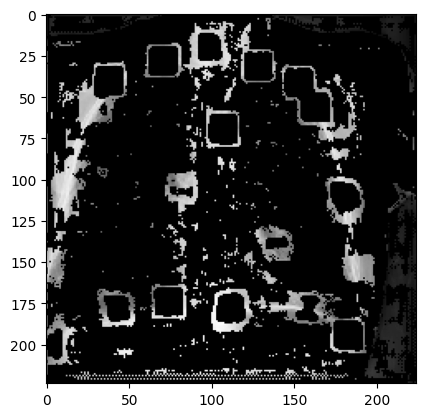

 22%|██▏       | 6/27 [00:08<00:28,  1.37s/it]

Predicted mask 1


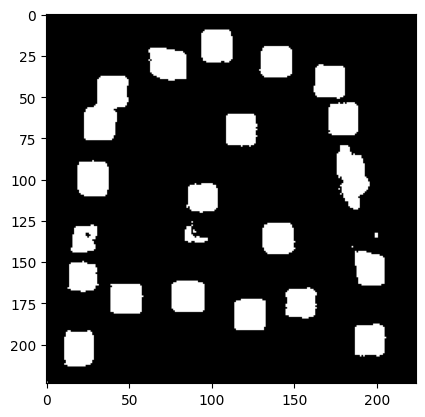

Predicted mask 3


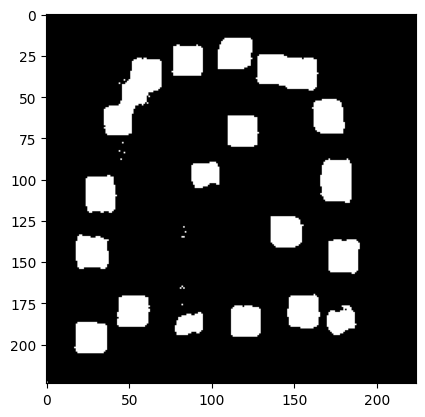

Image - predicted mask 1


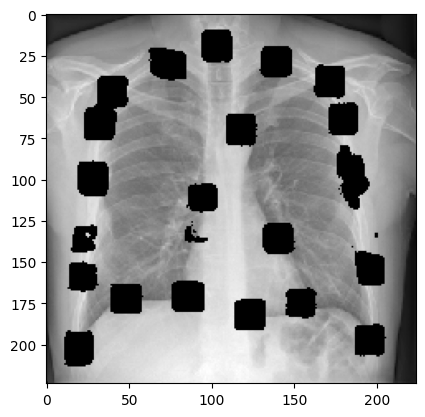

 22%|██▏       | 6/27 [00:09<00:33,  1.59s/it]


KeyboardInterrupt: ignored

In [ ]:
valid_epoch_loss, valid_epoch_acc = validate(best_model, validloader, criterion, accuracy_func)
print()
print(f"Validation loss: {valid_epoch_loss:.3f}")
print(f"Validation accuracy: {valid_epoch_acc:.3f}")

## Testing phase

In [ ]:
test_loss, test_acc = test(best_model, testloader, criterion, accuracy_func)
print(f"\nTest loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

100%|██████████| 53/53 [00:04<00:00, 12.96it/s]


Test loss: 0.294
Test accuracy: 0.397


In [ ]:
exactly20 = 0
less20 = 0
more20 = 0

for batch in testloader:

    # Extract the first batch
    images, masks, names = batch

    for i in range(len(images)):
      image = images[i].to(device).unsqueeze(0)
      mask = masks[i].to(device)
      name = names[i]

      outputs = best_model(image).squeeze()

      predMask = torch.sigmoid(outputs)
      predMask = predMask.permute(1,2,0).cpu().detach().numpy()

      firstChannelMask = predMask[:,:,0]
      firstChannelMask[firstChannelMask <= firstChannelMask.mean()] = 0
      firstChannelMask[firstChannelMask > firstChannelMask.mean()] = 1

      secondChannelMask = predMask[:,:,1]
      secondChannelMask[secondChannelMask <= secondChannelMask.mean()] = 0
      secondChannelMask[secondChannelMask > secondChannelMask.mean()] = 1

      finalMask1 = firstChannelMask.astype(np.int8)
      finalMask2 = secondChannelMask.astype(np.int8)

      final_img = 1-finalMask1+finalMask2
      final_img[final_img > 1] = 1
      plt.imshow(final_img, cmap='gray')
      plt.show()

      kernel = np.ones((7, 7), np.uint8)
      mask = cv2.erode(final_img.astype(np.uint8), kernel, iterations=1)
      plt.imshow(mask, cmap='gray')
      plt.show()

      contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

      # if len(contours) == 20:
      #   exactly20 += 1
      # elif len(contours) < 20:
      #   less20 += 1
      # else:
      #   more20 += 1

      coord = []

      for c in contours:
          # Calculate moments for each contour
          M = cv2.moments(c)

          # Calculate x,y coordinate of center
          if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            coord.append([cX,cY])
          else:
            cX, cY = 0, 0
            coord.append([cX,cY])

          cv2.circle(mask, (cX, cY), 1, (255, 255, 255), -1)

      # Display the image with centroids using pyplot
      # plt.imshow(mask, cmap='gray')
      # plt.axis('off')
      # plt.show()

      im = image.to('cpu')
      numpy_array = im.numpy()

      # Rescale the values from [0, 1] to [0, 255]
      scaled_array = (numpy_array * 255).astype('uint8')

      # Create a PIL Image from the array
      image = Image.fromarray(scaled_array.squeeze())

      # show_landmarks(image, coord, name)

    break

# print("Tacno", exactly20)
# print("Manje", less20)
# print("Vise", more20)
# print("sum", exactly20+less20+more20)
# print("Procenti")
# print("Tacno", exactly20/len_test_set)
# print("Manje", less20/len_test_set)
# print("Vise", more20/len_test_set)

Tacno 49
Manje 340
Vise 33
sum 422
Procenti
Tacno 0.11611374407582939
Manje 0.8056872037914692
Vise 0.07819905213270142


## Visualize the result

In [ ]:
img = cv2.imread('/content/CHEST_PA_PROBA.png')
# mask = cv2.imread(mask_path +'/VCX_s0000646_i1_PA.jpg')

img = cv2.resize(img, (224,224), interpolation = cv2.INTER_NEAREST)[:,:,0] / img.max()
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor[None, :]
img_tensor = img_tensor[None, :]
img_tensor = img_tensor.float()
img_tensor = img_tensor.to(device)

# mask = cv2.resize(mask, (224,224), interpolation = cv2.INTER_NEAREST)[:,:,0] / mask.max()
# mask_tensor = torch.from_numpy(mask)
# mask_tensor = mask_tensor[None, :]
# mask_tensor = mask_tensor[None, :]
# mask_tensor = mask_tensor.float()
# plt.imshow(mask,cmap='gray')

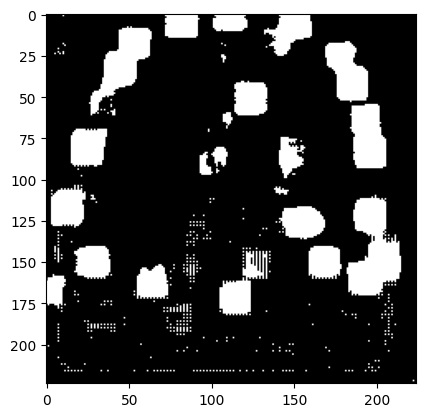

In [ ]:
predMask = model(img_tensor).squeeze()
predMask = torch.sigmoid(predMask)
predMask = predMask.permute(1,2,0).cpu().detach().numpy()

firstChannelMask = predMask[:,:,0]
firstChannelMask[firstChannelMask <= firstChannelMask.mean()] = 0
firstChannelMask[firstChannelMask > firstChannelMask.mean()] = 1

secondChannelMask = predMask[:,:,1]
secondChannelMask[secondChannelMask <= secondChannelMask.mean()] = 0
secondChannelMask[secondChannelMask > secondChannelMask.mean()] = 1

finalMask1 = firstChannelMask.astype(np.int8)
finalMask2 = secondChannelMask.astype(np.int8)

final_img = 1-finalMask1+finalMask2
final_img[final_img > 1] = 1
plt.imshow(finalMask2, cmap='gray')

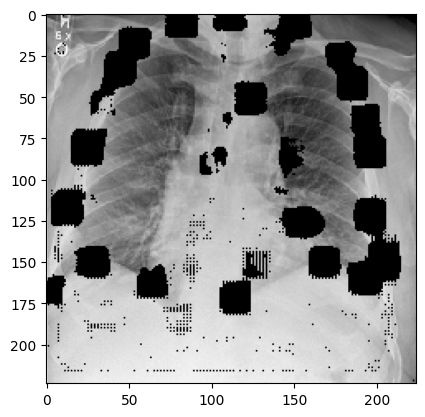

In [ ]:
plt.imshow(img-img*finalMask2,cmap='gray')

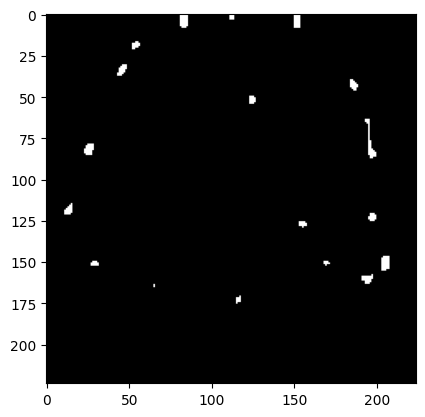

In [ ]:
kernel = np.ones((2, 2), np.uint8)
mask = cv2.erode(finalMask2.astype(np.uint8), kernel, iterations=1)
kernel = np.ones((7, 7), np.uint8)
mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
kernel = np.ones((8, 8), np.uint8)
mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
plt.imshow(mask, cmap='gray')

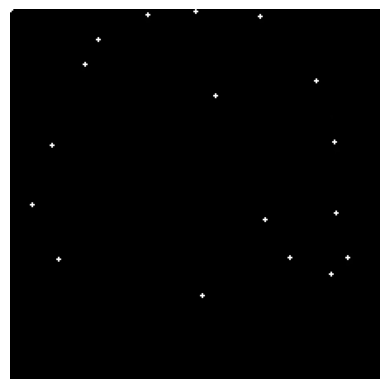

In [ ]:
# Find contours in the binary image
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

coord = []

for c in contours:
    # Calculate moments for each contour
    M = cv2.moments(c)

    # Calculate x,y coordinate of center
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      coord.append([cX,cY])
    else:
      cX, cY = 0, 0
      coord.append([cX,cY])

    cv2.circle(mask, (cX, cY), 1, (255, 255, 255), -1)

# Display the image with centroids using pyplot
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

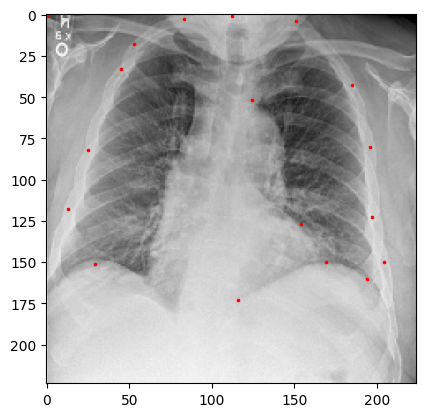

In [ ]:
show_landmarks(img, coord)